In [1]:
%matplotlib widget

In [57]:
from pathlib import Path

import numpy as np
from lotr import DATASET_LOCATION
from lotr import plotting as pltltr
from lotr.analysis.pool_cell_info import get_pooled_cell_info
from lotr.em.core import MIDLINES
from lotr.em.loading import load_skeletons_from_zip
from lotr.result_logging import ResultsLogger
from lotr.utils import linear_regression
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation
from tqdm import tqdm

logger = ResultsLogger()

COLS = pltltr.COLS
import flammkuchen as fl

In [3]:
from bg_atlasapi.core import Atlas

atlas = Atlas(DATASET_LOCATION.parent / "anatomy" / "ipn_zfish_0.5um_v1.6")

# Reference:
# Load the gad1b stack and the annotation from the IPN atlas:
bs = dict(frontal=(30, 180), vertical=(-25, 170), sagittal=(-50, 120))
plotter = pltltr.AtlasPlotter(
    atlas=atlas,
    structures=["ipn", "dors_ipn"],
    mask_slices=dict(frontal=slice(0, 120)),
    bounds_dict=dict(
        frontal=[bs["vertical"], bs["frontal"]],
        horizontal=[bs["sagittal"], bs["frontal"]],
        sagittal=[bs["vertical"], bs["sagittal"]],
    ),
)

In [47]:
# Load the EM and mirror neurons on one side:
em_path = DATASET_LOCATION.parent / "anatomy" / "all_ahb.k.zip"

neurons_list = load_skeletons_from_zip(em_path)

# for n in neurons_list:
#    n.mirror = True

# Select neurons with projections internal to the dIPN:

sel_neurons = [
    n
    for n in neurons_list
    if ("bilat" in n.comments or "bilatdend" in n.comments)
    and not "proj" in n.comments
    and not "diff" in n.comments
    and "dipn" in n.comments.split("_")
]

In [48]:
centroids = []
for n in sel_neurons:
    n.mirror = "right"
    centroids.append(
        [n.find_centroid_bifurcation(select=s) for s in ["dendrites", "axon"]]
    )

centroids = np.array(centroids)
norm_cm = centroids[:, 1, 2] - centroids[:, 1, 2].min()
norm_cm = norm_cm + 3
norm_cm = norm_cm / (norm_cm.max() + 0.01)

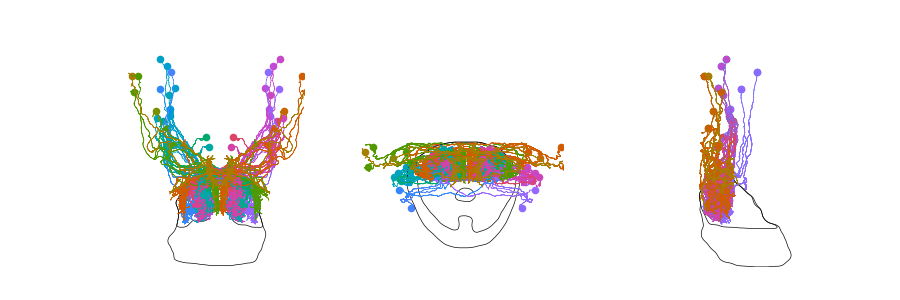

In [50]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):
    if "bilat" in neuron.comments and "dipn" in neuron.comments.split("_"):
        neuron.mirror = "right"
        phase_r = np.pi * c
        main_c = COLS["phase"](
            (phase_r + np.pi) / (2 * np.pi)
        )  # cm.get_cmap("Reds")(c)
        plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=True)
        neuron.mirror = "left"
        phase_l = -np.pi * c
        main_c = COLS["phase"]((phase_l + np.pi) / (2 * np.pi))
        plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=True)

In [52]:
dest_dir = Path(r"/Users/luigipetrucco/Desktop/4_vilim_preprint")
dest_dir.mkdir(exist_ok=True)

In [80]:
from lotr import A_FISH, LotrExperiment
from lotr.analysis.activity_profile import resample_and_shift

n_bins = 100
exp = LotrExperiment(A_FISH)
sorted_traces = exp.traces[:, exp.hdn_indexes[np.argsort(exp.rpc_angles)]]
resamp, _ = resample_and_shift(exp, n_bins_resampling=n_bins)

In [81]:
resamp.shape

(9900, 100)

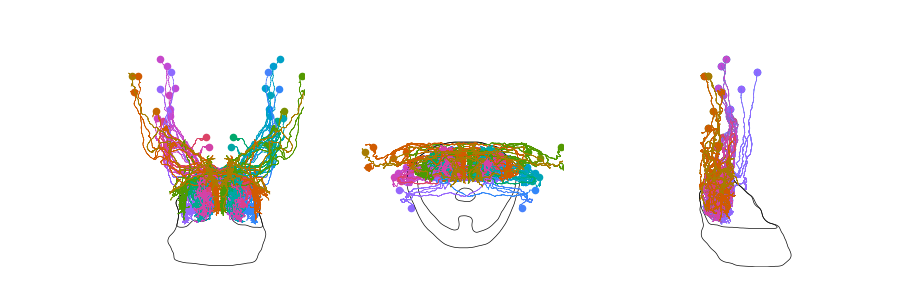

In [82]:
f, axs = plotter.generate_projection_plots()

lw = 0.5
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):

    orig_side = "left"
    if neuron._coords_ipn[neuron.soma_idx, 2] > 115:
        orig_side = "right"

    for i_s, side in enumerate(["left", "right"]):
        dest_subfold = dest_dir / side
        dest_subfold.mkdir(exist_ok=True)

        neuron.mirror = side
        phase = np.pi * c * (1 - i_s * 2)
        main_c = COLS["phase"]((phase + np.pi) / (2 * np.pi))  # cm.get_cmap("Reds")(c)
        plotter.plot_neurons(axs, neuron, c=main_c, lw=lw, rasterized=True)

        dendrites = neuron.generate_plotlines_from_skeleton(
            select="dendrites", space="ipn"
        )
        axon = neuron.generate_plotlines_from_skeleton(select="axon", space="ipn")

        trace_i = int(((n_bins - 1) * (ph + np.pi) / (2 * np.pi)))
        fl.save(
            dest_subfold / neuron.id,
            dict(
                dendrites=dendrites,
                axon=axon,
                soma=neuron.coords_ipn[neuron.soma_idx],
                orig_side=orig_side,
                phase=phase,
                norm_centroid_pos=c,
                phase_color=main_c,
                pseudo_activation=resamp[:, trace_i],
            ),
        )

In [ ]:
dendrites = []
axon = []
try:
    dendrites = neuron.generate_plotlines_from_skeleton(select="dendrites", space="ipn")
except ValueError:
    print("error for dendrite of n. ", neuron_id)

try:
    axon = neuron.generate_plotlines_from_skeleton(select="axon", space="ipn")
except ValueError:
    print("error for axon of n. ", neuron_id)

fl.save(
    dest_subfold / neuron.cell_id,
    dict(dendrites=dendrites, axon=axon, soma=neuron.coords_ipn[neuron.soma_idx]),
)

## recomputing the meshes

In [96]:
all_coords = []
for i, (neuron, c) in enumerate(zip(sel_neurons, norm_cm)):

    for i_s, side in enumerate(["left", "right"]):
        neuron.mirror = side
        lines = neuron.generate_plotlines_from_skeleton(select="all", space="ipn")
        all_coords.append(lines)
        all_coords.append([[np.nan, np.nan, np.nan]])

In [98]:
all_coords = np.concatenate(all_coords)

In [128]:
import meshio

In [130]:
?meshio.write

Signature:
meshio.write(
    filename,
    mesh: 'Mesh',
    file_format: 'str | None' = None,
    **kwargs,
)
Docstring:
Writes mesh together with data to a file.

:params filename: File to write to.
:type filename: str

:params point_data: Named additional point data to write to the file.
:type point_data: dict
File:      ~/anaconda3/envs/rplab/lib/python3.8/site-packages/meshio/_helpers.py
Type:      function


In [133]:
mesh_ipn.points

array([[ 63.60184097,  29.25692558,  58.01902008],
       [ 63.22173691,  29.40932465,  58.21506119],
       [ 63.47107315,  29.32756424,  58.5408783 ],
       ...,
       [110.30897522,  95.62954712,  58.30981445],
       [110.15675354,  95.66747284,  58.05335999],
       [110.40292358,  95.62089539,  57.8419838 ]])

In [138]:
source_dir = Path(
    "/Users/luigipetrucco/Google Drive/data/all_source_data/anatomy/ipn_zfish_0.5um_v1.6/meshes"
)
dest_dir = Path(
    "/Users/luigipetrucco/Google Drive/data/all_source_data/anatomy/ipn_zfish_0.5um_v1.7/meshes"
)
for path in source_dir.glob("*obj"):
    mesh_ipn = meshio.read(path)
    mesh_ipn.points[:, 1] += 55
    mesh_ipn.points[:, 2] += 50
    meshio.write(dest_dir / (path.stem + ".stl"), mesh_ipn, file_format="stl")

/Users/luigipetrucco/anaconda3/envs/rplab/lib/python3.8/site-packages/meshio/stl/_stl.py:184: RuntimeWarning: invalid value encountered in true_divide
  normals = (normals.T / nrm).T


In [141]:
mesh_ipn = trimesh.load("/Users/luigipetrucco/Google Drive/data/all_source_data/anatomy/ipn_zfish_0.5um_v1.7/meshes/4.obj")

(-12.9723743873329, 140.8463981223018, 25.257930183410643, 96.9004446029663)

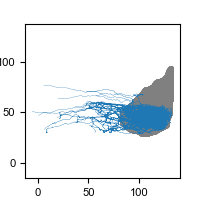

In [142]:
plt.figure(figsize=(2, 2))
plt.plot(all_coords[:, 1], all_coords[:, 0], lw=0.1)
plt.scatter(mesh_ipn.vertices[:, 1], mesh_ipn.vertices[:, 0], s=5, c=".5")
plt.axis("equal")